# **CSE 7324 Lab 7: Recurrent Network Architectures**
### *Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham*
---

In this lab, we chose a dataset of News Headlines for Sarcasm Detection on Kaggle.com. The dataset is collected from News in Brief and News in Photos on TheOnion and from real news headlines on HuffPost websites. 

This dataset has these advantages: 

1- We can reduce the sparsity and increase the chance of pre-trained embeddings since news headlines are written in a formal manner.

2- We can get high-quality labels with less noise since the data on TheOnion is used to publish sarcastic news.

3- The news headlines on this dataset are self-contained, which can help us to loosen the real sarcastic elements.

Our goal here is to provide a technology that would enable people whose first language is not English to more easily detect sarcasm. Speaking english fluently is largely a prequisite for detecting sarcasm, but deciphering sarcasm can be made even more difficult when done through text. This can cause people to misinterpret what others are saying leading to all sorts of embarassing incidents. 

Our technology could be installed in a browser plugin which would highlight sarcastic phrases, increasing the chances of detection for non-native English speakers.

### **1. Preparation**
---


In [1]:
import json
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import sequence
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding


Using TensorFlow backend.


In [2]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    

In [3]:
#create custom f1 metric from custom recall and precision
from keras.layers import concatenate
from keras import backend as K

def recall_m(y_true, y_pred): # recall is true positive / (total actual positive)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # actual positives are just y_true
        # recall is true positive / (total actual positive).. the episol is a small number to prevent divide by zero errors
        recall = true_positives / (possible_positives + K.epsilon()) 
        return recall

def precision_m(y_true, y_pred): #precision is true positives / (total predicted positives)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
        # (true positive / predicted positive).. the episol is a small number to prevent divide by zero errors
        precision = true_positives / (predicted_positives + K.epsilon())   
        return precision

def f1_m(y_true, y_pred): # f1 = 2 * (precision*recall / precision + recall)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 



The metric we will use to determine the performance of our model will be the micro-averaged F1 score.

Sarcasm is a tricky thing, and a false positive could lead to dramatic misinterpretations.. 

  &emsp;*Timmy was ecstatic to read that his romantic interest had been the first to say "I love you," until his hopes were crushed when the browser plugin (wrongly) mistook this for sarcasm.*
    
Similarly, a false negative could lead to equally awkward situations..

  &emsp;*Timmy was upset that he studied all weekend for a quiz on Monday that never took place. The browser plugin had failed to detect that the professor's email concerning the quiz on the Monday holiday to be largely sarcastic.*

For our purposes, these scenarios hold equal weight and our metric we have chosen to consider these into our accuracy is micro-averaged F1 in order to capture these preferences. Our negative-negatives are not of much concern, so this is a logical metric for our business case.

Since keras does not provide recall, precision, or f1 in their metrics package as a result of the 2.0 release, we will need to implement our own custom metric. Keras removed these functions as they are global metrics which were being approximated in batches (as keras runs in batches). However, for our purposes, this approximation will suffice. We found the following post on datascience stackexchange which helped detail this process below. Though fairly straightforward, we have provided comments to explain the code we have leveraged.

https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes


#### 1.1 Data Description
---

We thought with only ~26,000 instances of data (headlines), we would use the entire vocabulary and one hot encode the entire thing. We figured the vocabulary was not too expansive for this task.

Since we are dealing with headlines which are pretty short in length, we left our max article length at 500 which is probably overkill, but the point was just to use the entire headline.

In [5]:
tweets = []
article_link = []
headline=[]
y = []
#tokenizer = Tokenizer(num_words=1000)
for line in open('Data/Sarcasm_Headlines_Dataset.json', 'r'):
    tweets.append(json.loads(line))
    article_link.append(tweets[len(tweets)-1]['article_link'])
    headline.append(tweets[len(tweets)-1]['headline'])
    y.append(tweets[len(tweets)-1]['is_sarcastic'])

In [6]:
NUM_TOP_WORDS = None
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(headline)
sequences = tokenizer.texts_to_sequences(headline)

In [7]:
MAX_ART_LEN = 500 # maximum and minimum number of words
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))


Found 29656 unique tokens. Distilled to 29656 top words.


In [8]:
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
print(X.shape)

(26709, 500)


In [9]:
y_ohe = keras.utils.to_categorical(y)
print(y_ohe.shape)


(26709, 2)


#### 1.2 Metric Evaluation
---

We chose confusion matrix to evaluate our algorithm performance since it provided a table to visualize the performance of our algorithm on the text data.

In [10]:
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)  

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))  

[[2455  552]
 [1245 1090]]
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      3007
           1       0.66      0.47      0.55      2335

   micro avg       0.66      0.66      0.66      5342
   macro avg       0.66      0.64      0.64      5342
weighted avg       0.66      0.66      0.65      5342

0.6636091351553726


#### 1.3 Splitting Data
---

We dedided to choose Stratified ShuffleSplit cross-validator with 3 iterations, and split data into 80/20 for training and testing. We figured that we were sort of on the cusp of having enough data to ignore cross validation, but decided we should split. The shuffle split split will provide extra protection against any bias in the ordering of the initial data as well.

In [11]:
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=3, random_state=7,train_size = .8,test_size = .2,)

### **2. Modeling**
---


#### 2.1 Investigating Two RNNs
---

In [12]:
import numpy as np
NUM_CLASSES = 2

In [13]:

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))

input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 50)           1482850   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 1,488,002
Trainable params: 1,488,002
Non-trainable params: 0
_________________________________________________________________
None


## Network 1 

In [14]:
history1=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


 x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
 x = Dense(NUM_CLASSES, activation='sigmoid')(x)
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 rnn=Model(inputs=input_holder,outputs=x)
 rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]   
 history1.append(rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.6987 - acc: 0.5335 - f1_m: 0.5445 - val_loss: 0.6495 - val_acc: 0.6417 - val_f1_m: 0.6665
Epoch 2/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.6121 - acc: 0.6587 - f1_m: 0.6571 - val_loss: 0.5151 - val_acc: 0.7364 - val_f1_m: 0.7375
Epoch 3/5
21367/21367 [==============================] - 38s 2ms/step - loss: 0.4717 - acc: 0.7809 - f1_m: 0.7803 - val_loss: 0.4441 - val_acc: 0.7988 - val_f1_m: 0.7983
Epoch 4/5
21367/21367 [==============================] - 36s 2ms/step - loss: 0.3956 - acc: 0.8260 - f1_m: 0.8257 - val_loss: 0.4251 - val_acc: 0.8080 - val_f1_m: 0.8073
Epoch 5/5
21367/21367 [==============================] - 34s 2ms/step - loss: 0.3673 - acc: 0.8387 - f1_m: 0.8387 - val_loss: 0.4156 - val_acc: 0.8147 - val_f1_m: 0.8149
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

## Network 2 

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history2=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls = Sequential()
 rnnls.add(input_embed)
 rnnls.add(LSTM(50,dropout=0.2, recurrent_dropout=0.2))
 rnnls.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history2.append(rnnls.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 100s 5ms/step - loss: 0.4796 - acc: 0.7617 - f1_m: 0.7543 - val_loss: 0.3389 - val_acc: 0.8501 - val_f1_m: 0.8453
Epoch 2/5
21367/21367 [==============================] - 92s 4ms/step - loss: 0.3062 - acc: 0.8751 - f1_m: 0.8711 - val_loss: 0.3147 - val_acc: 0.8667 - val_f1_m: 0.8627
Epoch 3/5
21367/21367 [==============================] - 93s 4ms/step - loss: 0.2367 - acc: 0.9053 - f1_m: 0.9043 - val_loss: 0.3089 - val_acc: 0.8682 - val_f1_m: 0.8653
Epoch 4/5
21367/21367 [==============================] - 99s 5ms/step - loss: 0.2494 - acc: 0.9089 - f1_m: 0.9069 - val_loss: 0.3135 - val_acc: 0.8701 - val_f1_m: 0.8676
Epoch 5/5
21367/21367 [==============================] - 94s 4ms/step - loss: 0.1844 - acc: 0.9279 - f1_m: 0.9273 - val_loss: 0.3372 - val_acc: 0.8725 - val_f1_m: 0.8706
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342

## Network 3 

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
history3=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnngd = Sequential()
 rnngd.add(input_embed)
 rnngd.add(GRU(50,dropout=0.2, recurrent_dropout=0.2))
 rnngd.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history3.append(rnngd.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnngd.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 77s 4ms/step - loss: 0.4745 - acc: 0.7664 - f1_m: 0.7622 - val_loss: 0.3413 - val_acc: 0.8506 - val_f1_m: 0.8494
Epoch 2/5
21367/21367 [==============================] - 73s 3ms/step - loss: 0.2917 - acc: 0.8800 - f1_m: 0.8783 - val_loss: 0.3140 - val_acc: 0.8648 - val_f1_m: 0.8630
Epoch 3/5
21367/21367 [==============================] - 74s 3ms/step - loss: 0.2412 - acc: 0.9055 - f1_m: 0.9044 - val_loss: 0.3154 - val_acc: 0.8684 - val_f1_m: 0.8670
Epoch 4/5
21367/21367 [==============================] - 74s 3ms/step - loss: 0.2095 - acc: 0.9185 - f1_m: 0.9180 - val_loss: 0.3169 - val_acc: 0.8686 - val_f1_m: 0.8686
Epoch 5/5
21367/21367 [==============================] - 74s 3ms/step - loss: 0.1871 - acc: 0.9279 - f1_m: 0.9274 - val_loss: 0.3140 - val_acc: 0.8693 - val_f1_m: 0.8691
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

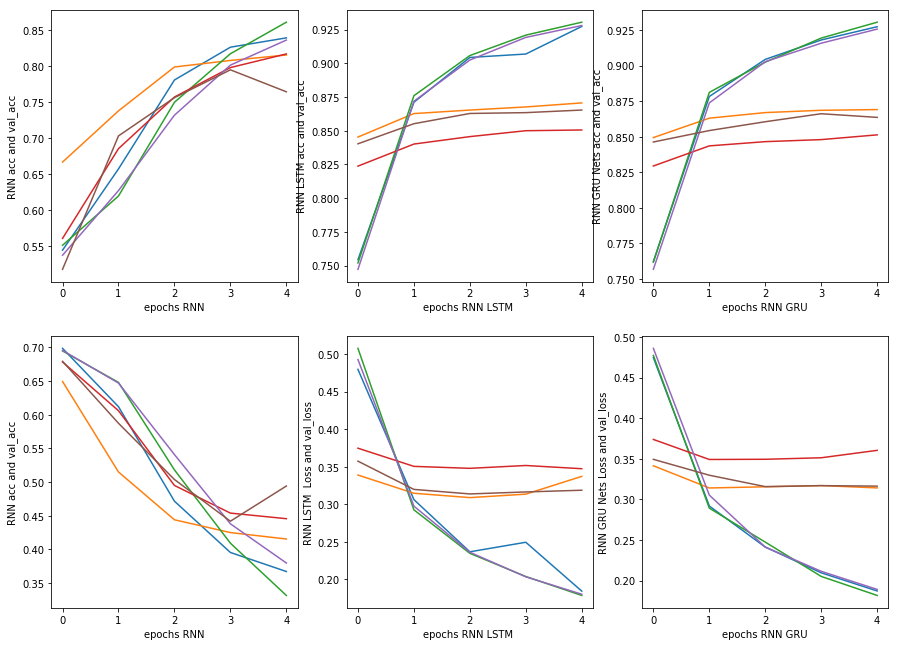

In [17]:
plt.figure(figsize=(15,11))
plt.subplot(2,3,1)
plt.ylabel('RNN acc and val_acc')
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['f1_m'])

plt.plot(history1[0].history['val_f1_m'])
plt.plot(history1[1].history['f1_m'])

plt.plot(history1[1].history['val_f1_m'])
plt.plot(history1[2].history['f1_m'])

plt.plot(history1[2].history['val_f1_m'])
plt.subplot(2,3,4)
plt.ylabel('RNN acc and val_acc')
plt.plot(history1[0].history['loss'])
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['val_loss'])

plt.plot(history1[1].history['loss'])
plt.plot(history1[1].history['val_loss'])
plt.plot(history1[2].history['loss'])
plt.plot(history1[2].history['val_loss']) 
         
plt.subplot(2,3,2)
plt.ylabel('RNN LSTM acc and val_acc')
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[0].history['f1_m'])
plt.plot(history2[0].history['val_f1_m'])
plt.plot(history2[1].history['f1_m'])
plt.plot(history2[1].history['val_f1_m'])
plt.plot(history2[2].history['f1_m'])
plt.plot(history2[2].history['val_f1_m'])
plt.subplot(2,3,5)
plt.plot(history2[0].history['loss'])
plt.ylabel('RNN LSTM  Loss and val_loss')
plt.plot(history2[0].history['val_loss'])
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[1].history['loss'])
plt.plot(history2[1].history['val_loss'])
plt.plot(history2[2].history['loss'])
plt.plot(history2[2].history['val_loss'])
plt.subplot(2,3,3)
plt.ylabel('RNN GRU Nets acc and val_acc')
plt.xlabel('epochs RNN GRU')
plt.plot(history3[0].history['f1_m'])
plt.plot(history3[0].history['val_f1_m'])
plt.plot(history3[1].history['f1_m'])
plt.plot(history3[1].history['val_f1_m'])
plt.plot(history3[2].history['f1_m'])
plt.plot(history3[2].history['val_f1_m'])
plt.subplot(2,3,6)
plt.plot(history3[0].history['loss'])
plt.ylabel('RNN GRU Nets Loss and val_loss')
plt.plot(history3[0].history['val_loss'])
plt.xlabel('epochs RNN GRU')
plt.plot(history3[1].history['loss'])
plt.plot(history3[1].history['val_loss'])
plt.plot(history3[2].history['loss'])
plt.plot(history3[2].history['val_loss'])




The graphs per epochs show that GRU and LSTM did better than simple RNN, but it's still not obvious which classfier did the best so we will use mcnemar test for further investigation.

#### 2.2 RNN Chaining
---

In [18]:
# copy ytest for reshape
yhat_sim=[]
yhat_ls=[]
yhat_gru=[]
for train_index, test_index in sss.split(X, y_ohe):
    yhat_sim.append(np.argmax(rnn.predict(X_test), axis=1))
    yhat_ls.append(np.argmax(rnnls.predict(X_test), axis=1))
    yhat_gru.append(np.argmax(rnngd.predict(X_test), axis=1))
    

In [20]:
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd

    
# build contingency table
contab = pd.DataFrame({'sim_correct':np.equal(y_test_ohe[:,1], yhat_sim[0]).flatten(),'ls_correct':np.equal(y_test_ohe[:,1], yhat_ls[0]).flatten(),'gre_correct':np.equal(y_test_ohe[:,1], yhat_gru[0]).flatten()},index=range(0,len(y_test_ohe[:,1])))
contab1 = pd.DataFrame({'sim_correct1':np.equal(y_test_ohe[:,1], yhat_sim[1]).flatten(),'ls_correct1':np.equal(y_test_ohe[:,1], yhat_ls[1]).flatten(),'gre_correct1':np.equal(y_test_ohe[:,1], yhat_gru[1]).flatten()},index=range(0,len(y_test_ohe[:,1])))
contab2 = pd.DataFrame({'sim_correct2':np.equal(y_test_ohe[:,1], yhat_sim[2]).flatten(),'ls_correct2':np.equal(y_test_ohe[:,1], yhat_ls[2]).flatten(),'gre_correct2':np.equal(y_test_ohe[:,1], yhat_gru[2]).flatten()},index=range(0,len(y_test_ohe[:,1])))
xtab = pd.crosstab(contab.sim_correct, contab.ls_correct)
xtab1 = pd.crosstab(contab.ls_correct, contab.gre_correct)
xtab.sort_index(ascending=False, inplace=True)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('lst test was superior to the simple test because it got more corrent predection in the true false cell ')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
print('GRE test was superior to the other test because it got more corrent predection than the other two ')

xtab = pd.crosstab(contab1.sim_correct1, contab1.ls_correct1)
xtab1 = pd.crosstab(contab1.ls_correct1, contab1.gre_correct1)
xtab.sort_index(ascending=False, inplace=True)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('lst test was superior to the simple test because it got more corrent predection in the true false cell ')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
print('GRE test was superior to the other test because it got more corrent predection than the other two ')
xtab.sort_index(ascending=False, inplace=True)
xtab = pd.crosstab(contab2.sim_correct2, contab2.ls_correct2)
xtab1 = pd.crosstab(contab2.ls_correct2, contab2.gre_correct2)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('lst test was superior to the simple test because it got more corrent predection in the true false cell ')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
print('GRE test was superior to the other test because it got more corrent predection than the other two ')

# This example taken from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/ and modified for use in this lab
# calculate mcnemar test
result = mcnemar(xtab, exact=False, correction=True)
result1 = mcnemar(xtab1,exact=False, correction=True)
# print findings
print('statistic=%.2f, p-value=%.2f' % (result.statistic, result.pvalue))

print('statistic=%.2f, p-value=%.2f' % (result1.statistic, result1.pvalue))
# compare p-value to alpha
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')

Contingency table for McNemar Test:
 ls_correct   True   False
sim_correct              
True          3804    274
False          845    419 

lst test was superior to the simple test because it got more corrent predection in the true false cell 
Contingency table for McNemar Test:
 gre_correct  False  True 
ls_correct               
False          621     72
True            82   4567 

GRE test was superior to the other test because it got more corrent predection than the other two 
Contingency table for McNemar Test:
 ls_correct1   True   False
sim_correct1              
True           3804    274
False           845    419 

lst test was superior to the simple test because it got more corrent predection in the true false cell 
Contingency table for McNemar Test:
 gre_correct1  False  True 
ls_correct1               
False           621     72
True             82   4567 

GRE test was superior to the other test because it got more corrent predection than the other two 
Contingency ta

A contingency table compares two classifiers with the true data and shows how much of the data the two classifiers got right and how much they got wrong and if anyone predicted more correct values 

gre_correct2  False  True 
ls_correct2               
False           606     97
True             87   4552 


In the comparison between GRE and LS we found that both classifiers got 4552 of the cases correct and 606 wrong, but what we are interested in is the value 97 which indicate that GRU got 97 cases correct where ls got them wrong which is higher than 87 which is the opposite.

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history4=[]

for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls1 = Sequential()
 rnnls1.add(input_embed)
 rnnls1.add(GRU(50, recurrent_activation='sigmoid',dropout=0.25,recurrent_dropout=0.25))
 rnnls1.add(Dense(NUM_CLASSES, activation='softmax'))
 
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history4.append(rnnls1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls1.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 78s 4ms/step - loss: 0.4685 - acc: 0.7743 - f1_m: 0.7743 - val_loss: 0.3395 - val_acc: 0.8467 - val_f1_m: 0.8467
Epoch 2/5
21367/21367 [==============================] - 73s 3ms/step - loss: 0.2963 - acc: 0.8788 - f1_m: 0.8788 - val_loss: 0.3134 - val_acc: 0.8637 - val_f1_m: 0.8637
Epoch 3/5
21367/21367 [==============================] - 73s 3ms/step - loss: 0.2389 - acc: 0.9041 - f1_m: 0.9041 - val_loss: 0.3065 - val_acc: 0.8701 - val_f1_m: 0.8701
Epoch 4/5
21367/21367 [==============================] - 71s 3ms/step - loss: 0.2036 - acc: 0.9216 - f1_m: 0.9216 - val_loss: 0.3076 - val_acc: 0.8695 - val_f1_m: 0.8695
Epoch 5/5
21367/21367 [==============================] - 72s 3ms/step - loss: 0.1766 - acc: 0.9331 - f1_m: 0.9331 - val_loss: 0.3077 - val_acc: 0.8712 - val_f1_m: 0.8712
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

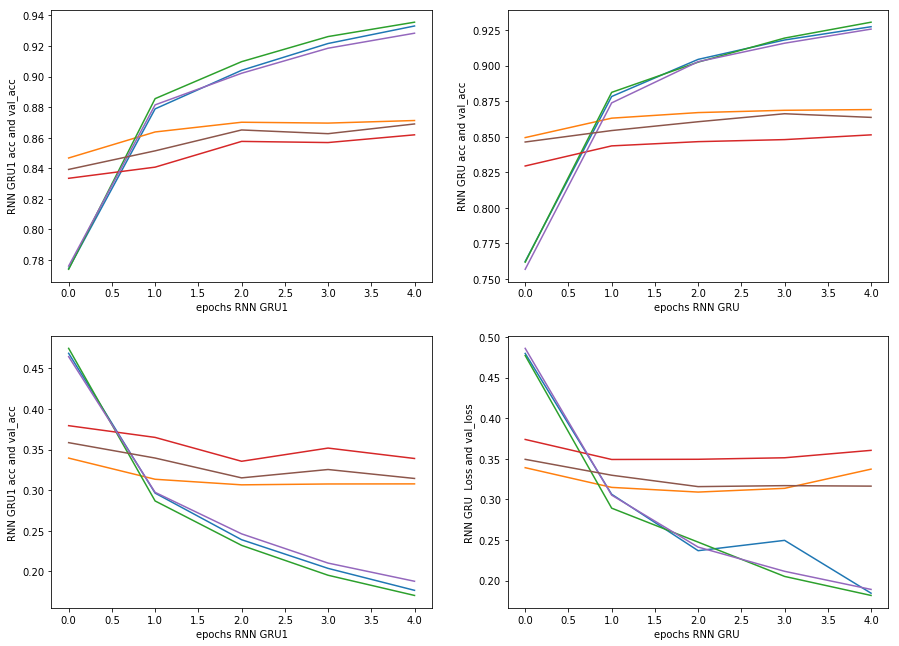

In [22]:
plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['f1_m'])

plt.plot(history4[0].history['val_f1_m'])
plt.plot(history4[1].history['f1_m'])

plt.plot(history4[1].history['val_f1_m'])
plt.plot(history4[2].history['f1_m'])

plt.plot(history4[2].history['val_f1_m'])
plt.subplot(2,2,3)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.plot(history4[0].history['loss'])
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['val_loss'])

plt.plot(history4[1].history['loss'])
plt.plot(history4[1].history['val_loss'])
plt.plot(history4[2].history['loss'])
plt.plot(history4[2].history['val_loss']) 
         
plt.subplot(2,2,2)
plt.ylabel('RNN GRU acc and val_acc')
plt.xlabel('epochs RNN GRU ')
plt.plot(history3[0].history['f1_m'])
plt.plot(history3[0].history['val_f1_m'])
plt.plot(history3[1].history['f1_m'])
plt.plot(history3[1].history['val_f1_m'])
plt.plot(history3[2].history['f1_m'])
plt.plot(history3[2].history['val_f1_m'])
plt.subplot(2,2,4)
plt.plot(history2[0].history['loss'])
plt.ylabel('RNN GRU  Loss and val_loss')
plt.plot(history2[0].history['val_loss'])
plt.xlabel('epochs RNN GRU ')
plt.plot(history3[1].history['loss'])
plt.plot(history3[1].history['val_loss'])
plt.plot(history3[2].history['loss'])
plt.plot(history3[2].history['val_loss'])


In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history5=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls2 = Sequential()
 rnnls2.add(input_embed)
 rnnls2.add(GRU(50,return_sequences=True, recurrent_activation='sigmoid',dropout=0.25,recurrent_dropout=0.25))
 rnnls2.add(GRU(10,dropout=0.1,recurrent_dropout=0.1))   
 rnnls2.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history5.append(rnnls2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls2.summary())


TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 124s 6ms/step - loss: 0.4693 - acc: 0.7691 - f1_m: 0.7611 - val_loss: 0.3399 - val_acc: 0.8529 - val_f1_m: 0.8489
Epoch 2/5
21367/21367 [==============================] - 122s 6ms/step - loss: 0.2909 - acc: 0.8819 - f1_m: 0.8753 - val_loss: 0.3263 - val_acc: 0.8613 - val_f1_m: 0.8586
Epoch 3/5
21367/21367 [==============================] - 123s 6ms/step - loss: 0.2566 - acc: 0.9019 - f1_m: 0.8978 - val_loss: 0.3145 - val_acc: 0.8660 - val_f1_m: 0.8587
Epoch 4/5
21367/21367 [==============================] - 123s 6ms/step - loss: 0.2871 - acc: 0.8992 - f1_m: 0.8933 - val_loss: 0.3083 - val_acc: 0.8677 - val_f1_m: 0.8611
Epoch 5/5
21367/21367 [==============================] - 122s 6ms/step - loss: 0.1897 - acc: 0.9285 - f1_m: 0.9217 - val_loss: 0.3089 - val_acc: 0.8665 - val_f1_m: 0.8617
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 

#### 2.3 RNN Evaluation
---

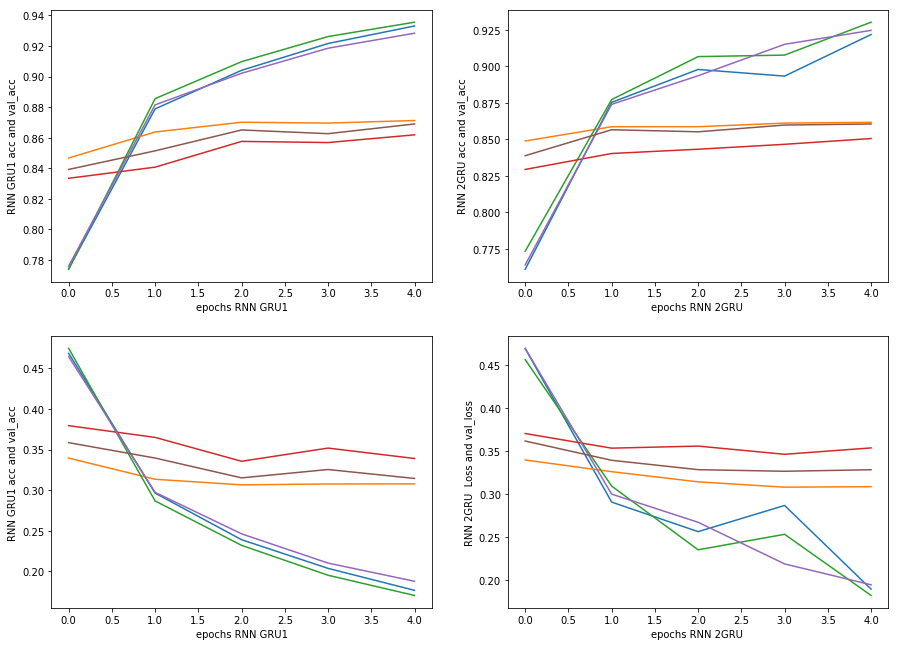

In [24]:
plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['f1_m'])

plt.plot(history4[0].history['val_f1_m'])
plt.plot(history4[1].history['f1_m'])

plt.plot(history4[1].history['val_f1_m'])
plt.plot(history4[2].history['f1_m'])

plt.plot(history4[2].history['val_f1_m'])
plt.subplot(2,2,3)
plt.ylabel('RNN GRU1 acc and val_acc')
plt.plot(history4[0].history['loss'])
plt.xlabel('epochs RNN GRU1')
plt.plot(history4[0].history['val_loss'])

plt.plot(history4[1].history['loss'])
plt.plot(history4[1].history['val_loss'])
plt.plot(history4[2].history['loss'])
plt.plot(history4[2].history['val_loss']) 
         
plt.subplot(2,2,2)
plt.ylabel('RNN 2GRU acc and val_acc')
plt.xlabel('epochs RNN 2GRU ')
plt.plot(history5[0].history['f1_m'])
plt.plot(history5[0].history['val_f1_m'])
plt.plot(history5[1].history['f1_m'])
plt.plot(history5[1].history['val_f1_m'])
plt.plot(history5[2].history['f1_m'])
plt.plot(history5[2].history['val_f1_m'])
plt.subplot(2,2,4)
plt.plot(history5[0].history['loss'])
plt.ylabel('RNN 2GRU  Loss and val_loss')
plt.plot(history5[0].history['val_loss'])
plt.xlabel('epochs RNN 2GRU ')
plt.plot(history5[1].history['loss'])
plt.plot(history5[1].history['val_loss'])
plt.plot(history5[2].history['loss'])
plt.plot(history5[2].history['val_loss'])


In [26]:
yhat1 = np.argmax(rnnls2.predict(X_test), axis=1)
cm1 = mt.confusion_matrix(y_test_ohe[:,1],yhat1)
cm1 = cm1/np.sum(cm1,axis=1)[:,np.newaxis]
print(cm1)


[[0.89422756 0.10577244]
 [0.17398721 0.82601279]]


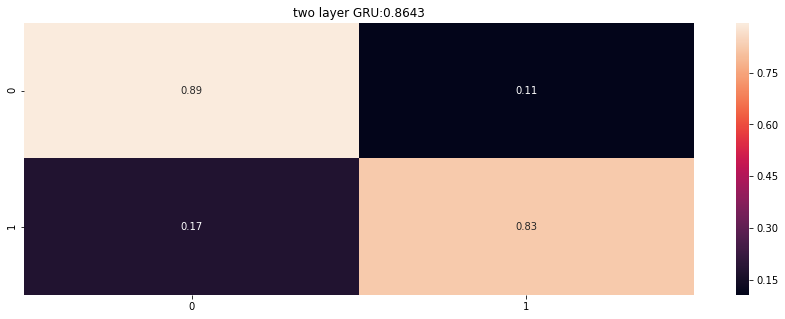

In [27]:
summarize_net(rnnls2, X_test, y_test_ohe[:,1], title_text='two layer GRU:')


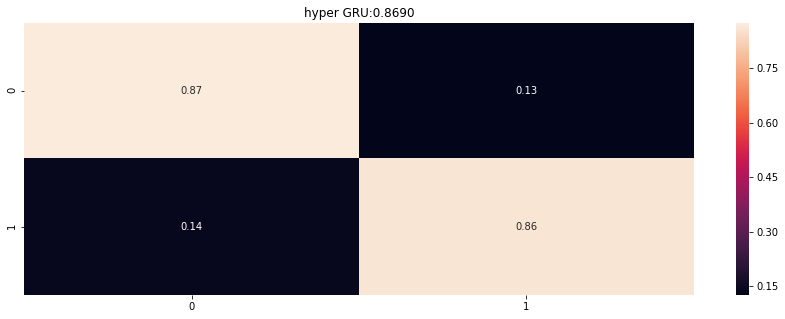

In [28]:
summarize_net(rnnls1, X_test, y_test_ohe[:,1], title_text='hyper GRU:')

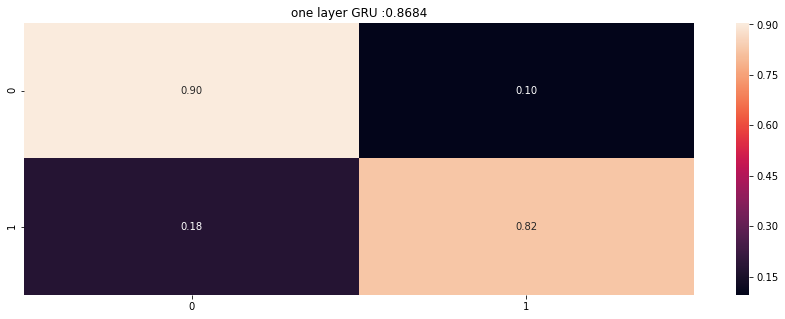

In [29]:
summarize_net(rnngd, X_test, y_test_ohe[:,1], title_text='one layer GRU :')

In [30]:
yhat2 = np.argmax(rnnls1.predict(X_test), axis=1)
cm2 = mt.confusion_matrix(y_test_ohe[:,1],yhat2)
cm2 = cm2/np.sum(cm2,axis=1)[:,np.newaxis]
print(cm2)

[[0.87420754 0.12579246]
 [0.13773987 0.86226013]]


In [31]:
yhat3 = np.argmax(rnngd.predict(X_test), axis=1)
cm3 = mt.confusion_matrix(y_test_ohe[:,1],yhat3)
cm3 = cm3/np.sum(cm3,axis=1)[:,np.newaxis]
print(cm3)

[[0.90423757 0.09576243]
 [0.17739872 0.82260128]]


In [33]:
# debugging option
#pd.options.display.max_rows = 50

from statsmodels.stats.contingency_tables import mcnemar

# copy ytest for reshape


# build contingency table
contab = pd.DataFrame({'gru_correct':np.equal(y_test_ohe[:,1], yhat3).flatten(),'hyper_gru_correct':np.equal(y_test_ohe[:,1], yhat2).flatten(),'gru2_correct':np.equal(y_test_ohe[:,1], yhat1).flatten()},index=range(0,len(y_test_ohe)))
xtab = pd.crosstab(contab.gru_correct, contab.hyper_gru_correct)
xtab1 = pd.crosstab(contab.hyper_gru_correct, contab.gru2_correct)
xtab.sort_index(ascending=False, inplace=True)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')
print('Contingency table for McNemar Test:\n', xtab1, '\n')
# This example taken from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/ and modified for use in this lab
# calculate mcnemar test
result = mcnemar(xtab, exact=False, correction=True)
result1 = mcnemar(xtab1,exact=False, correction=True)
# print findings
print('statistic=%.2f, p-value=%.2f' % (result.statistic, result.pvalue))
print('statistic=%.2f, p-value=%.2f' % (result1.statistic, result1.pvalue))
# compare p-value to alpha
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')

Contingency table for McNemar Test:
 hyper_gru_correct  True   False
gru_correct                    
True                4528    111
False                114    589 

Contingency table for McNemar Test:
 gru2_correct       False  True 
hyper_gru_correct              
False                598    102
True                 127   4515 

statistic=0.02, p-value=0.89
statistic=2.52, p-value=0.11
Same proportions of errors


mcnemar test was ran on these three classfiers :

1- normal GRU

2- optimized GRu

3- two layer GRU 


First on the comparson between normal GRU and optimzed GRU p-value is higher than .05 which means there is a signifcant difference between the classfier, and both of the classfiers got 4576 correct prediction and 603 wrong. On the other hand, optimzed GRU was superior by accurately predicting 90 cases that normal GRU was not able to.

Then, optimized GRU was compared with two layers GRU, with p-value of .26 we found that optimized GRU is superior to the other classfier which means that adding another layer worsened that network and caused it to overfit.


### **3. Exceptional Work: t-SNE**
---


In [34]:
%%time
from sklearn.manifold import TSNE

# get weights from best perfoming model
rnngd_weights = rnngd.layers[0].get_weights()[0]

words = []
num_words = 100
for word, i in word_index.items():
    words.append(word)

rnngd_tsne = TSNE(n_components=2).fit_transform(rnngd_weights)

Wall time: 10min 24s


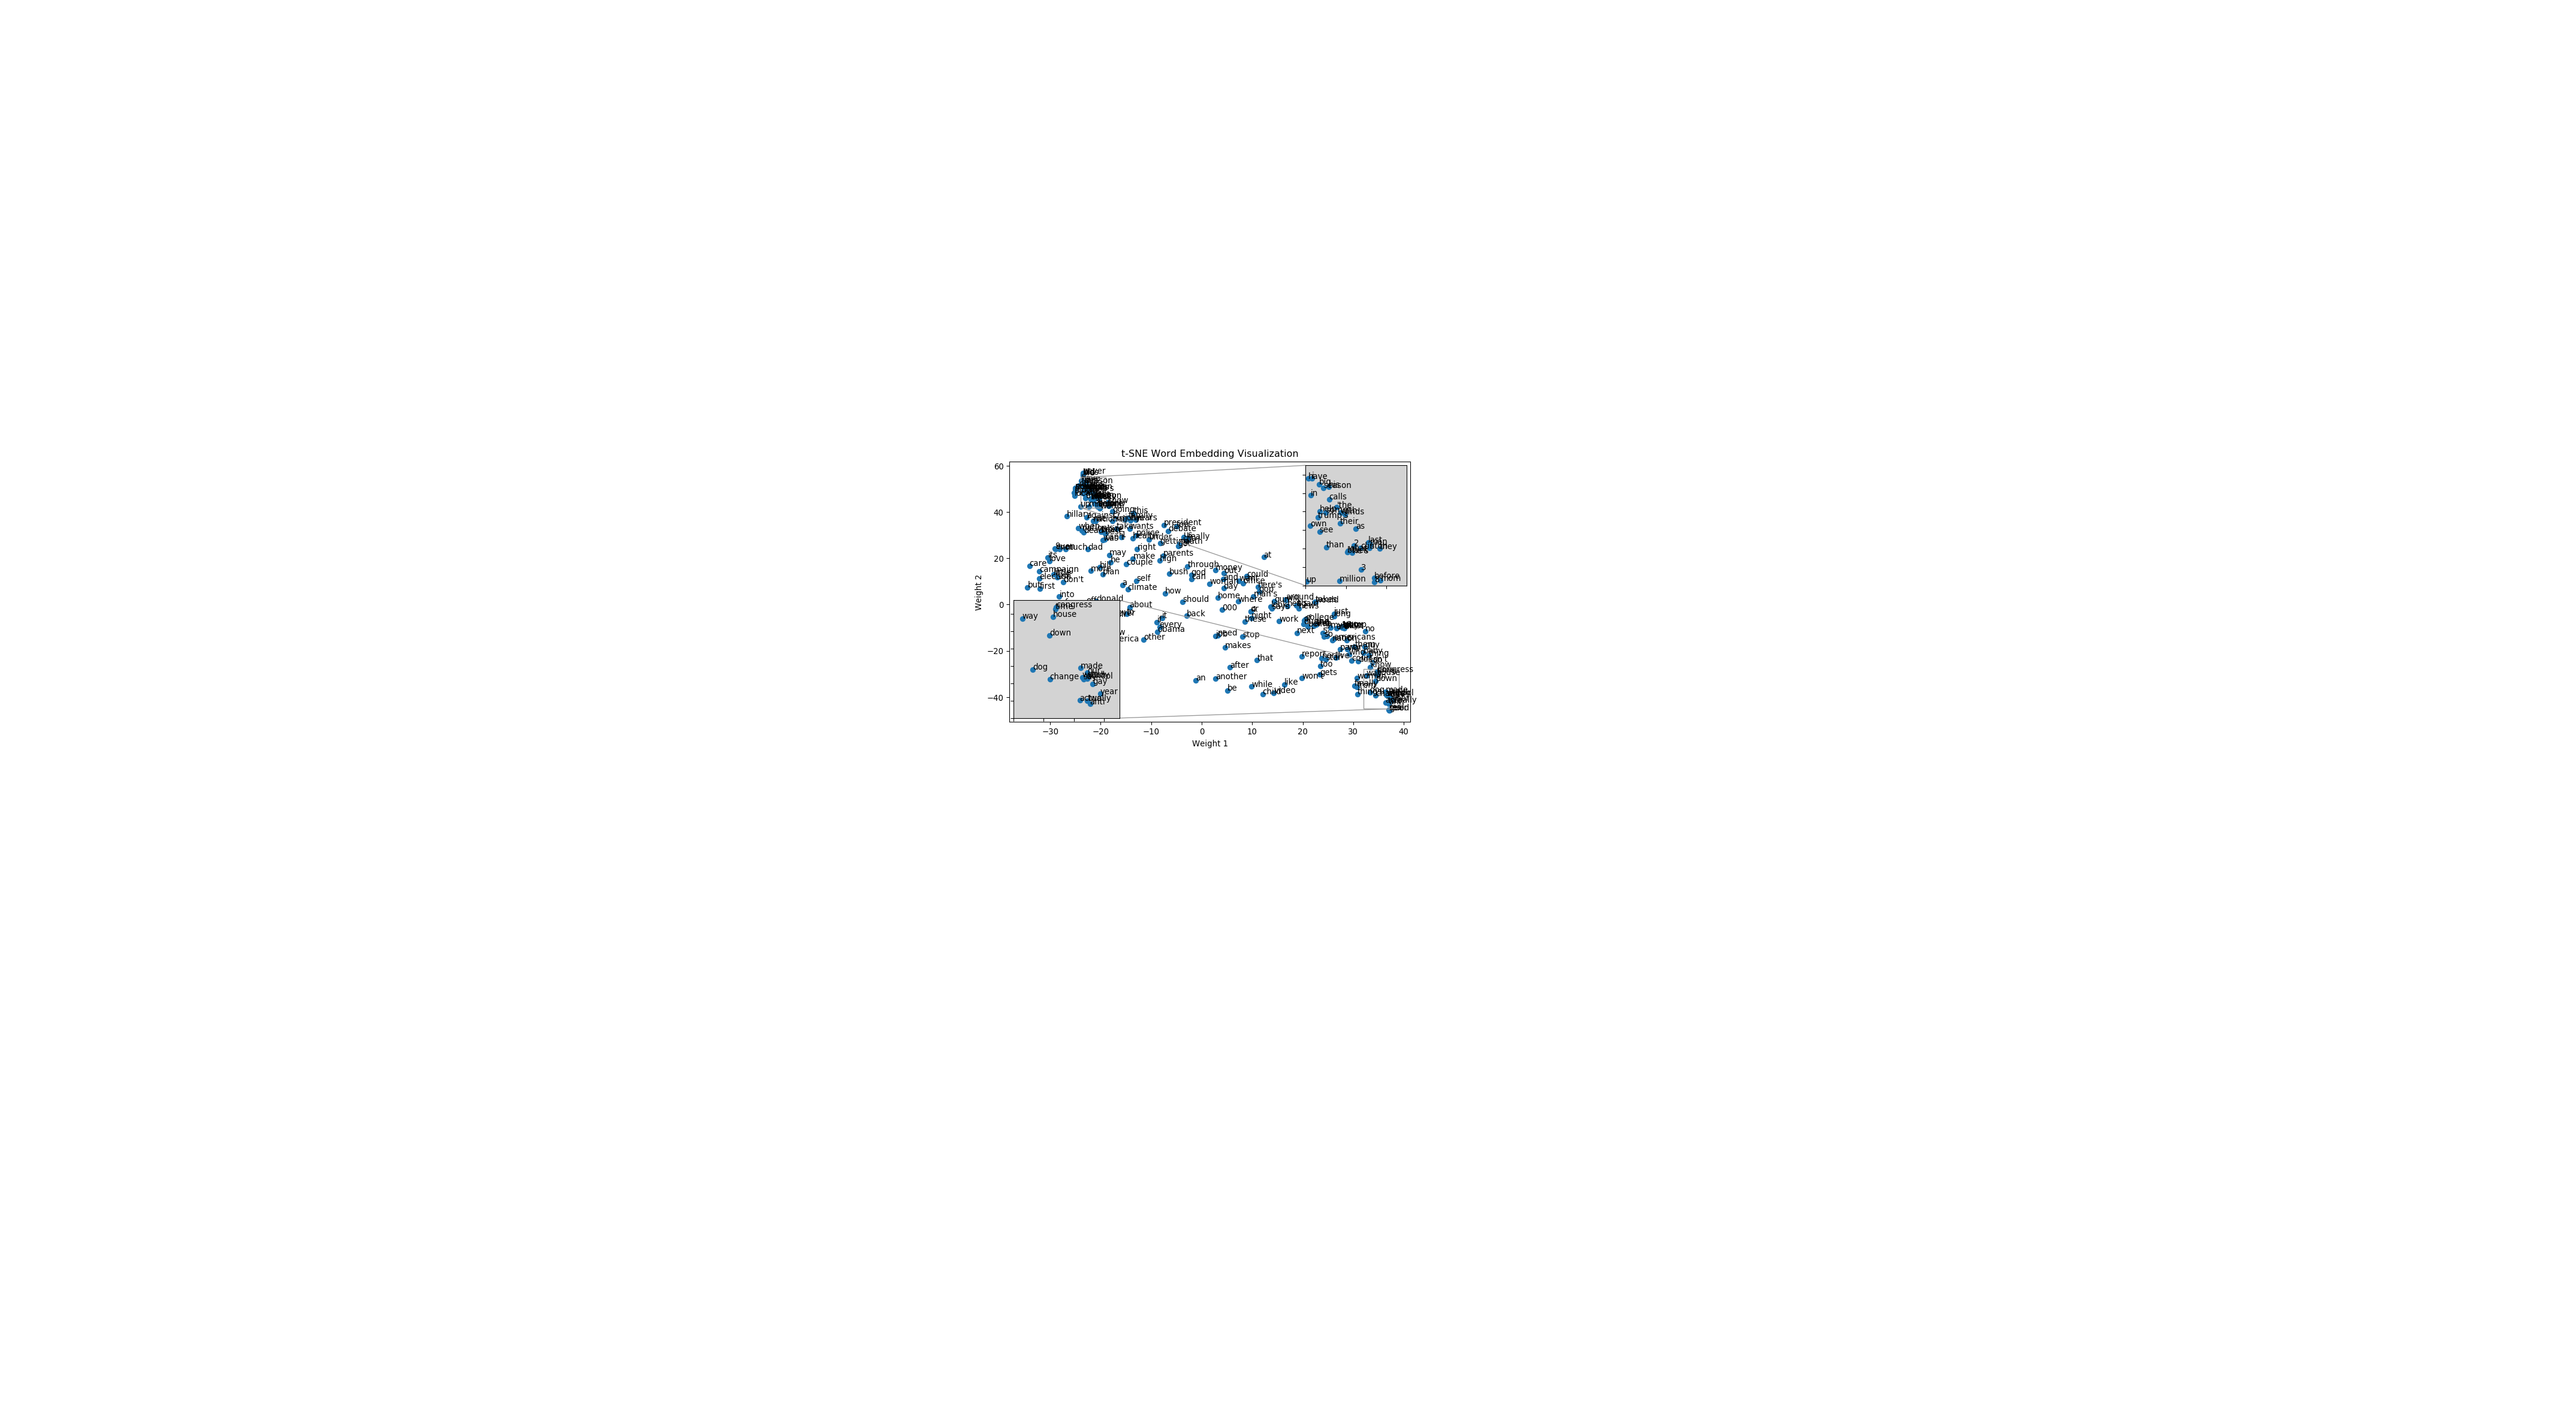

In [47]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


num_words=250
fig, ax = plt.subplots(figsize=(9, 6), dpi = 96)
plt.title('t-SNE Word Embedding Visualization')

data = rnngd_tsne[0:num_words, 0], rnngd_tsne[0:num_words, 1]
ax.scatter(rnngd_tsne[0:num_words, 0], rnngd_tsne[0:num_words, 1])

for i in range(num_words):
    ax.annotate(words[i], (rnngd_tsne[i, 0], rnngd_tsne[i, 1]))
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")


axTopLeft = zoomed_inset_axes(ax, 4, loc=1, axes_kwargs={"facecolor" : "lightgray"})
axTopLeft.scatter(rnngd_tsne[0:num_words, 0], rnngd_tsne[0:num_words, 1])
for i in range(num_words):
    axTopLeft.annotate(words[i], (rnngd_tsne[i, 0], rnngd_tsne[i, 1]))
    
x1, x2, y1, y2 = -24, -19, 42, 55 # specify the limits
axTopLeft.set_xlim(x1, x2) # apply the x-limits
axTopLeft.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)
mark_inset(ax, axTopLeft, loc1=2, loc2=3, fc="none", ec=".6")




axBottomRight = zoomed_inset_axes(ax, 3, loc=3, axes_kwargs={"facecolor" : "lightgray"})
axBottomRight.scatter(rnngd_tsne[0:num_words, 0], rnngd_tsne[0:num_words, 1])
for i in range(num_words):
    axBottomRight.annotate(words[i], (rnngd_tsne[i, 0], rnngd_tsne[i, 1]))
    
x1, x2, y1, y2 = 32, 39, -45, -28 # specify the limits
axBottomRight.set_xlim(x1, x2) # apply the x-limits
axBottomRight.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)
mark_inset(ax, axBottomRight, loc1=1, loc2=4, fc="none", ec=".6")

plt.show()



As shown in the scatter plot above, there are 2 main clusters where a large percentage of words in this vocabulary subset reside. One note of interest is that the upper left cluster contains more emotional words which may signify some level of sarcasm while the bottom right cluster contains more neutral words which might signify non-sarcasm. There are many words in between these two clusters and these words vary quite a lot. 

Additionally, the words seem to become more political as you move toward the upper left corner, with words like hillary, president, debate, trump, and right which could all have political tones, though there are exceptions in the bottom right.

Of chief irony is that "trump" is found in the upper left, while both "house" and "congress" are found in the bottom right. 

### **4. References**
---


[1] https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home

[2] https://stackabuse.com/text-classification-with-python-and-scikit-learn/

[3] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

[4] https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

[5] https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes